In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
#from os import walk
#import re

import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

from math import sqrt
from joblib import Parallel, delayed

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


ModuleNotFoundError: No module named 'joblib'

In [2]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [3]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    return {"S": result, "L": heat["L"], "D": heat["D"], "R": heat["R"]}

def calc_hc(st, T):

    fe = mp.mpf(1.0) * np.array([e for e, S in st['S'].items()])
    fS = mp.mpf(1.0) * np.array([S for e, S in st['S'].items()])

    exp = np.frompyfunc(mp.exp, 1, 1)
    w = exp(fS - fe / T)

    Z = w.sum()
    E = (w * fe).sum()
    E_sq = (w * fe * fe).sum()
    E_qr = (w * fe * fe * fe * fe).sum()
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant, Z
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq))), Z


In [4]:
T_crit = {}

In [6]:
D = 0.0
L = [x for x in [8, 12, 16, 20, 24, 32, 48, 64, 80, 96] if x >=0]

R = [32768, 131072]

cool, heat = [{
    "q": 3,
    "D": D,
    "L": l,
    #"R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
} for l in L], [{
    "q": 3,
    "D": D,
    "L": l,
    #"R" : R,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
} for l in L]
print('D={}'.format(D))

parameters = []
for c, h in zip(cool, heat):
    try:
        c['R'] = R[0]
        h['R'] = R[0]
        parameters.append(read_tuple_files((c, h)))
    except:
        try:
            c['R'] = R[1]
            h['R'] = R[1]
            parameters.append(read_tuple_files((c, h)))
        except:
            pass
        
for i, x in enumerate(tqdm(parameters)):
    parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])
print('L in {}'.format(", ".join([str(x["stitched"]["L"]) for x in parameters]) ))
print('R in {}'.format(", ".join([str(x["heat"]["R"]) for x in parameters]) ))


D=0.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()



L in 8, 12, 16, 20, 24, 32, 48, 64, 80, 96
R in 131072, 131072, 131072, 131072, 131072, 131072, 32768, 32768, 32768, 32768


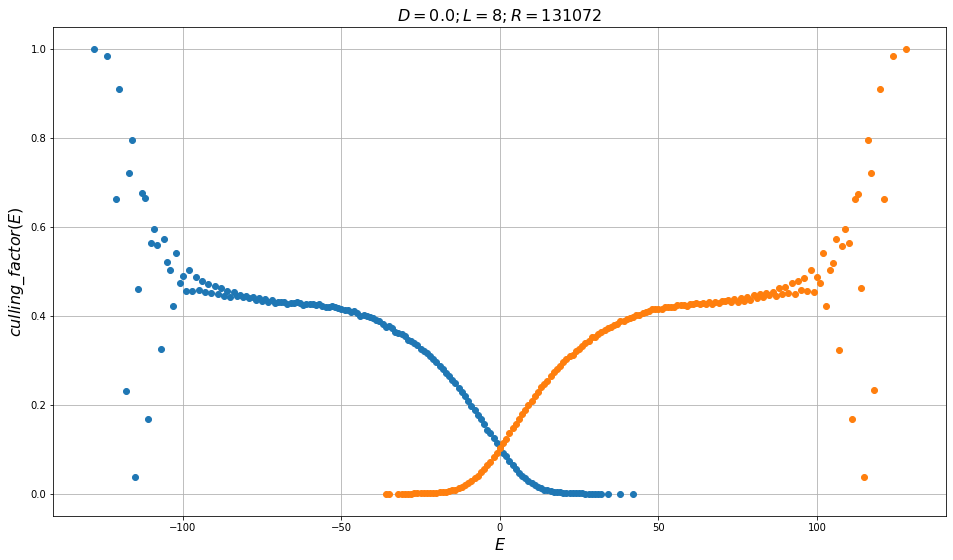

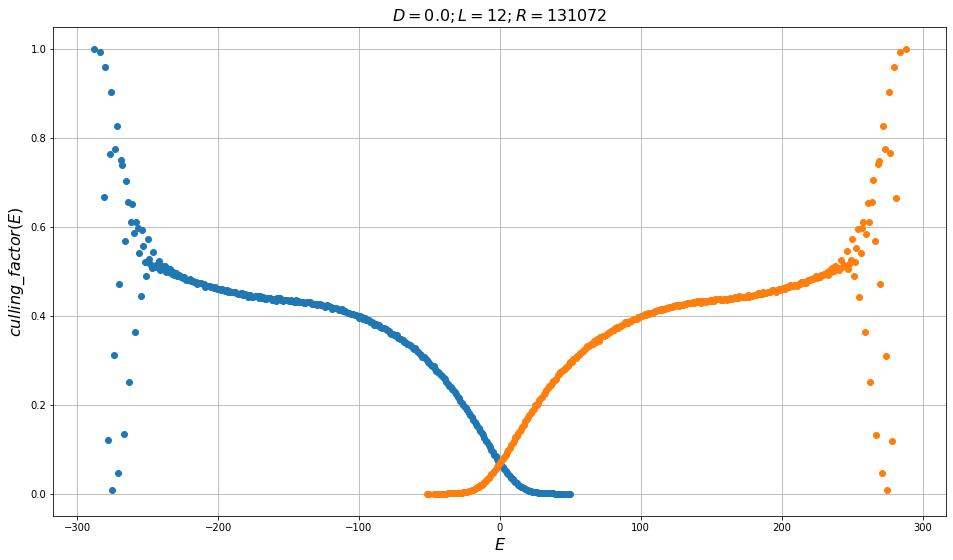

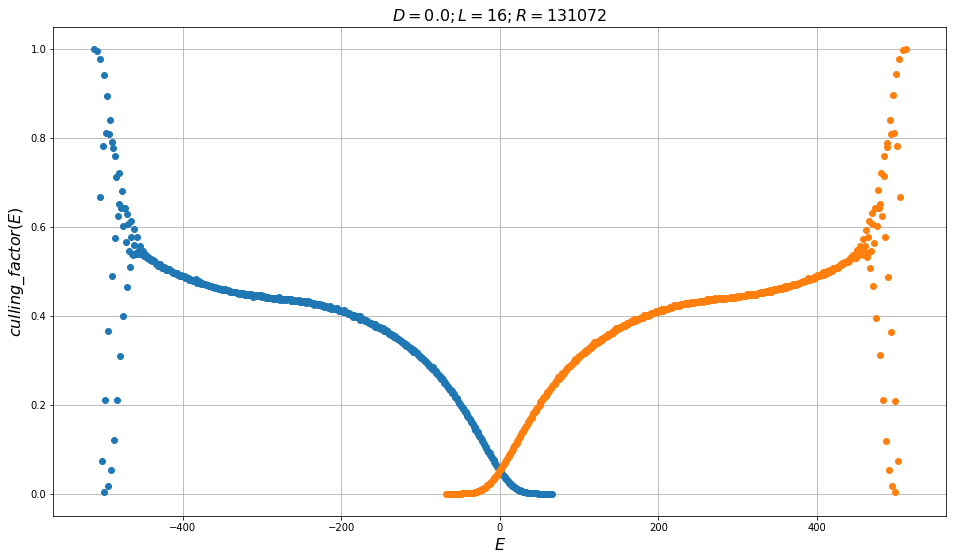

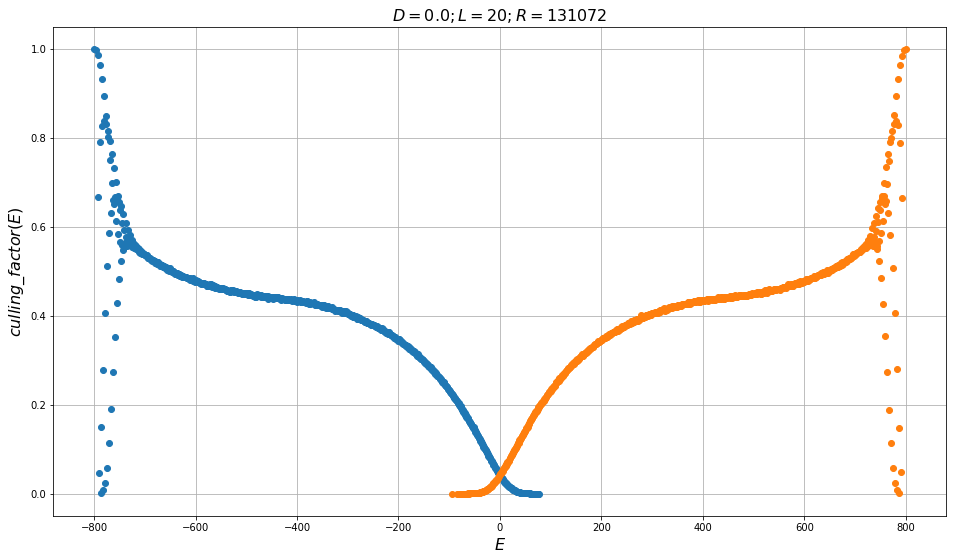

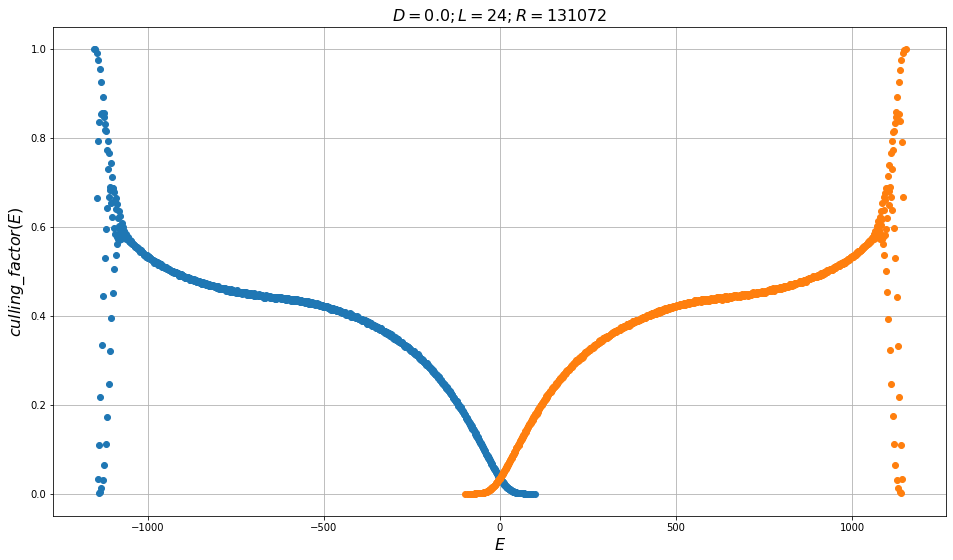

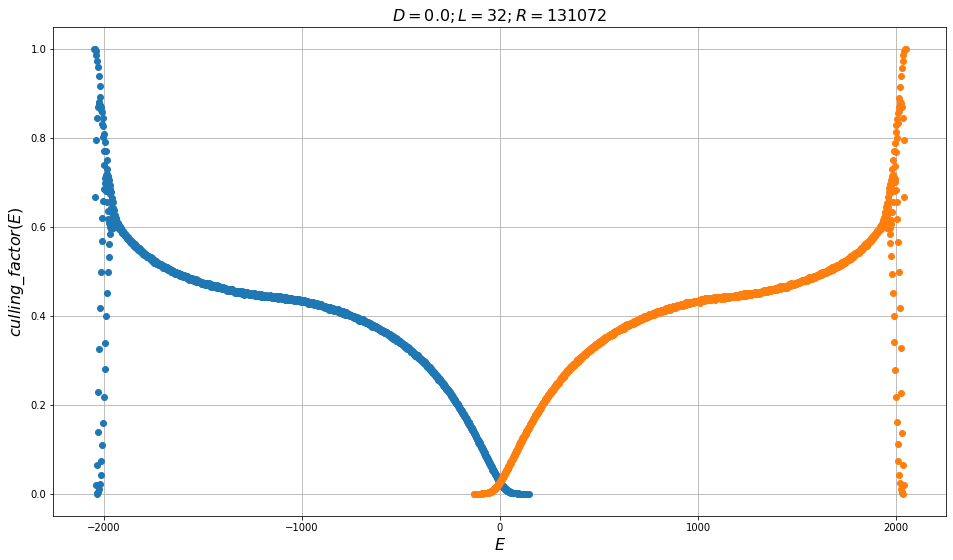

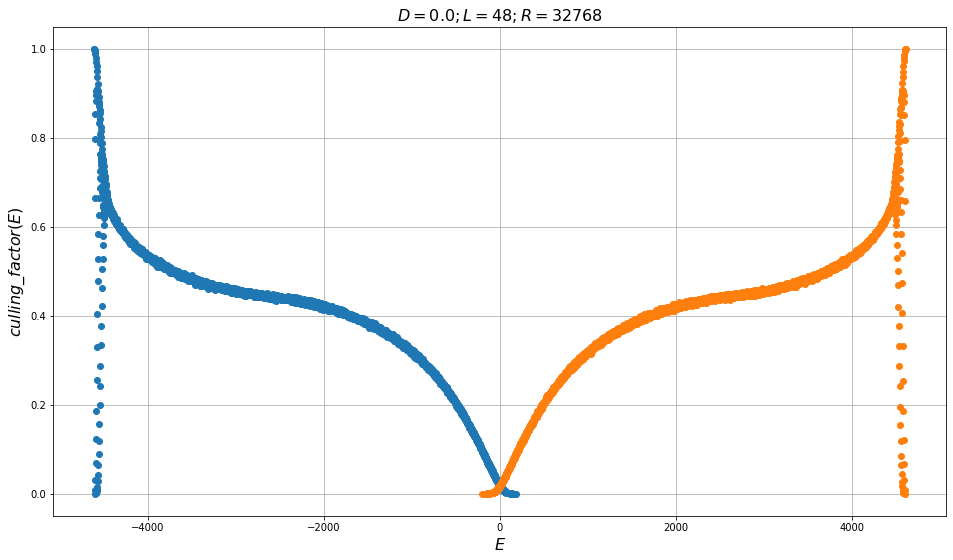

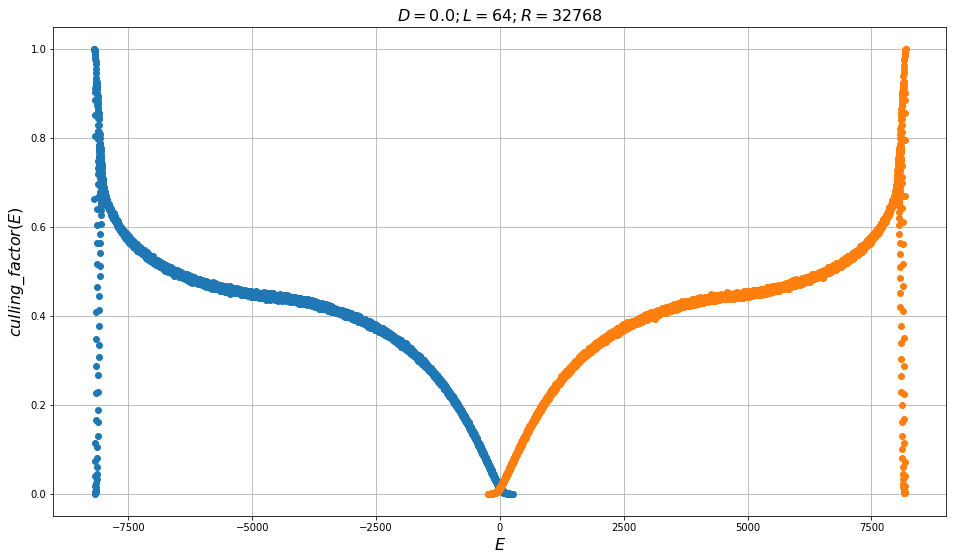

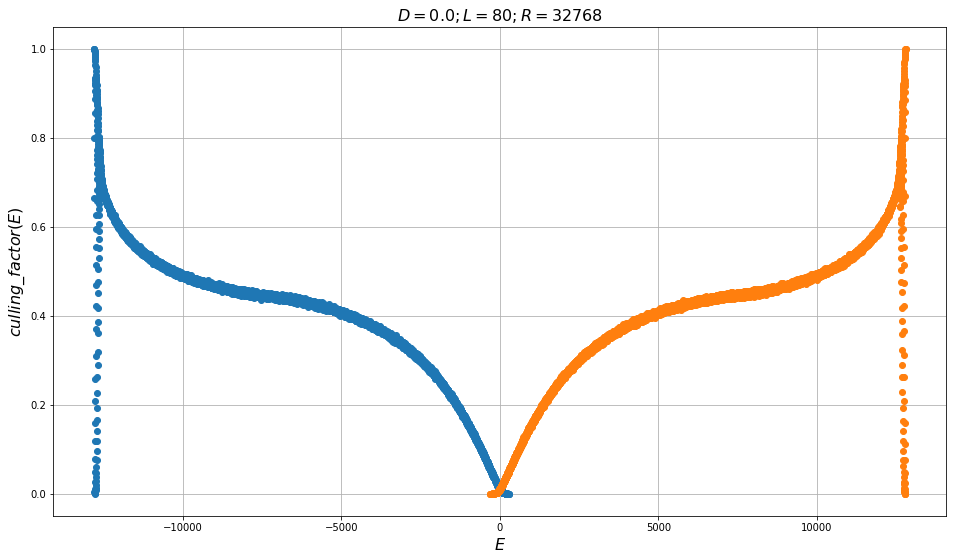

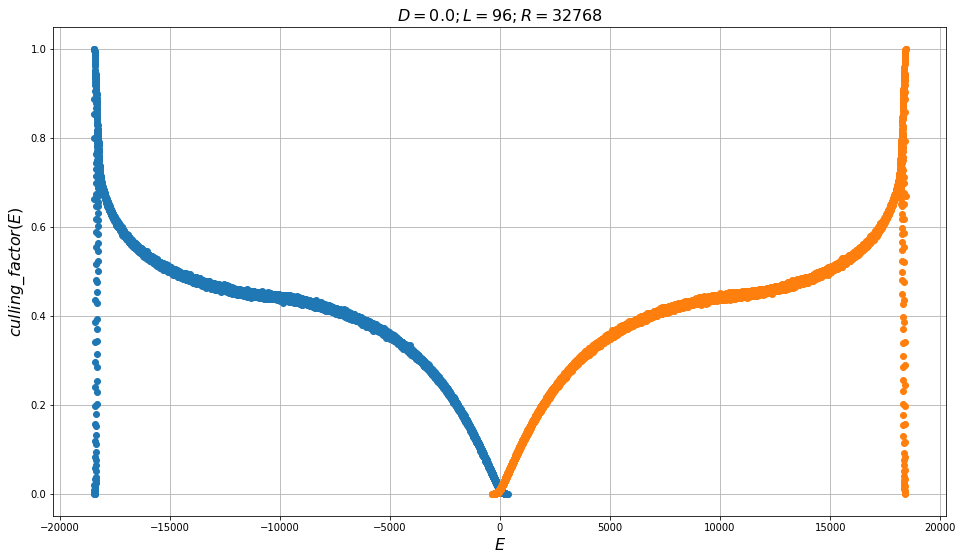

In [7]:
for p in parameters:
    cool, heat, st = p['cool'], p['heat'], p['stitched']

    plt.figure(figsize=(16, 9))

    plt.plot([x for x in cool['culling_factor']], [y for x, y in cool['culling_factor'].items()], 'o')
    plt.plot([x for x in heat['culling_factor']], [y for x, y in heat['culling_factor'].items()], 'o')
    plt.grid()

    plt.title("$D={}; L={}; R={}$".format(st["D"], st["L"], st["R"]), fontsize=16)
    plt.ylabel('$culling\_factor(E)$', fontsize=16)
    plt.xlabel('$E$', fontsize=16)
    plt.show()
    #plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


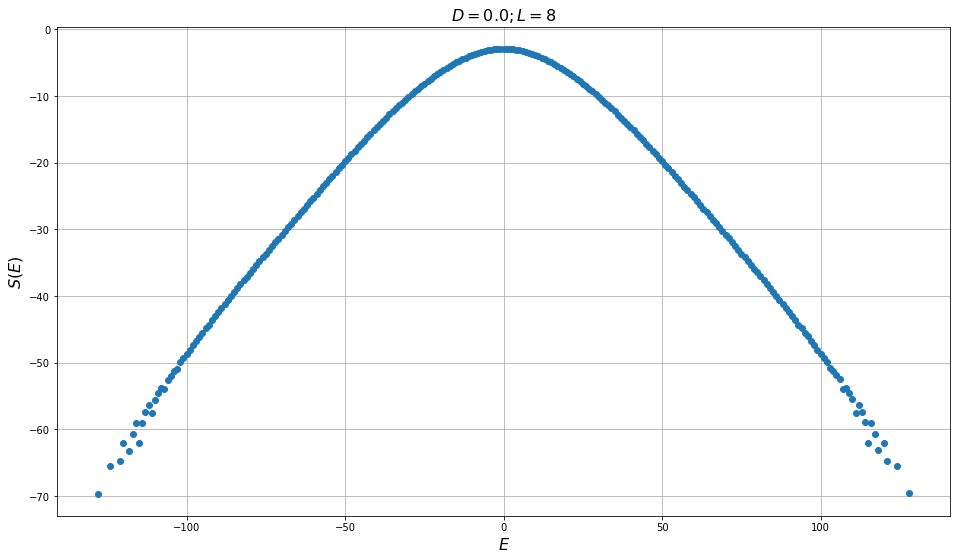

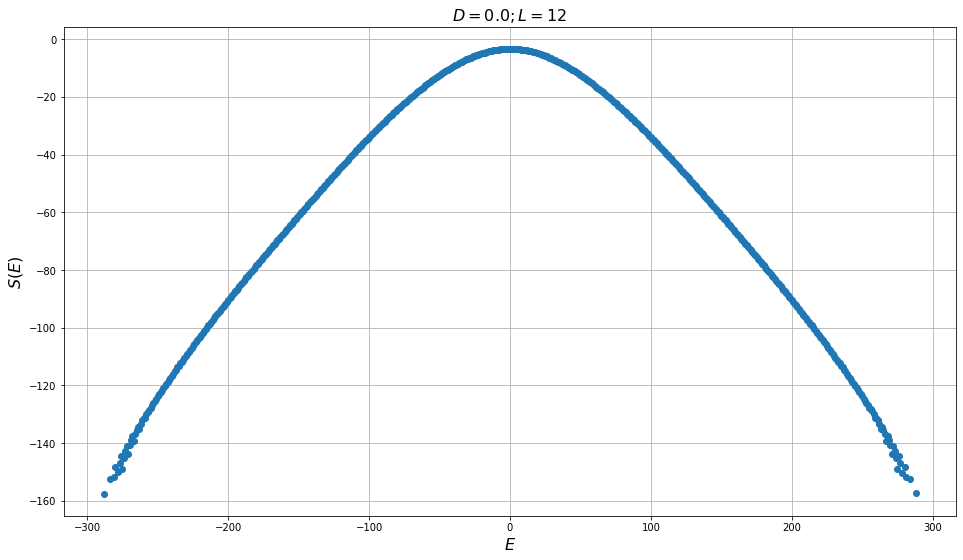

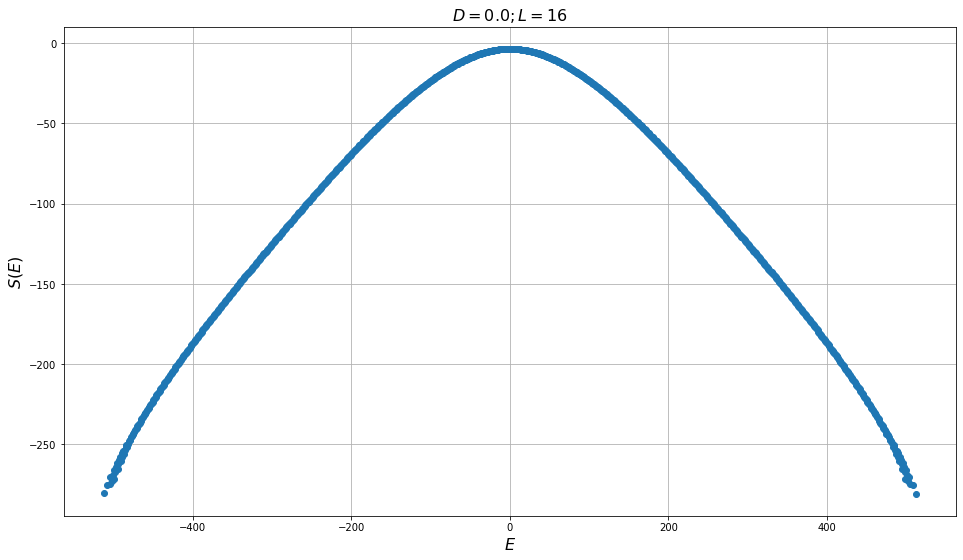

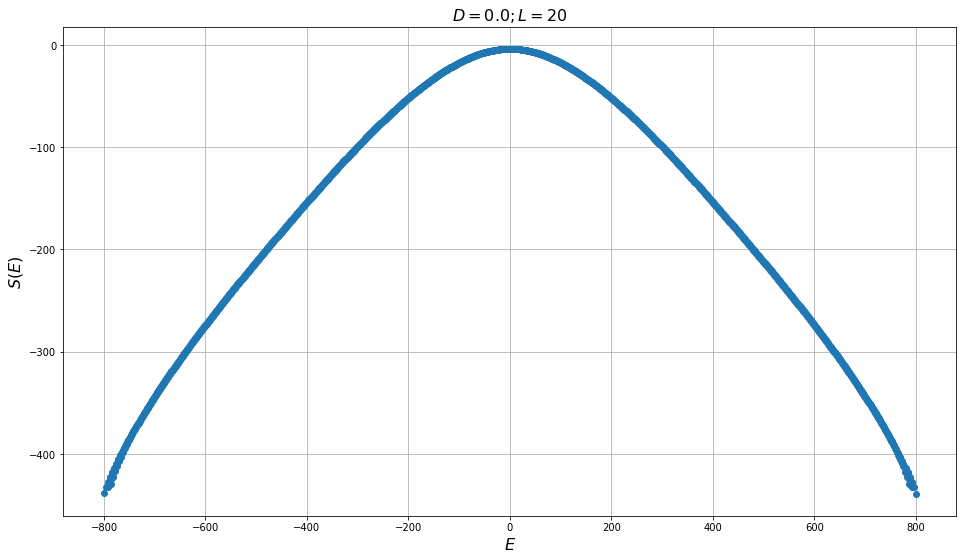

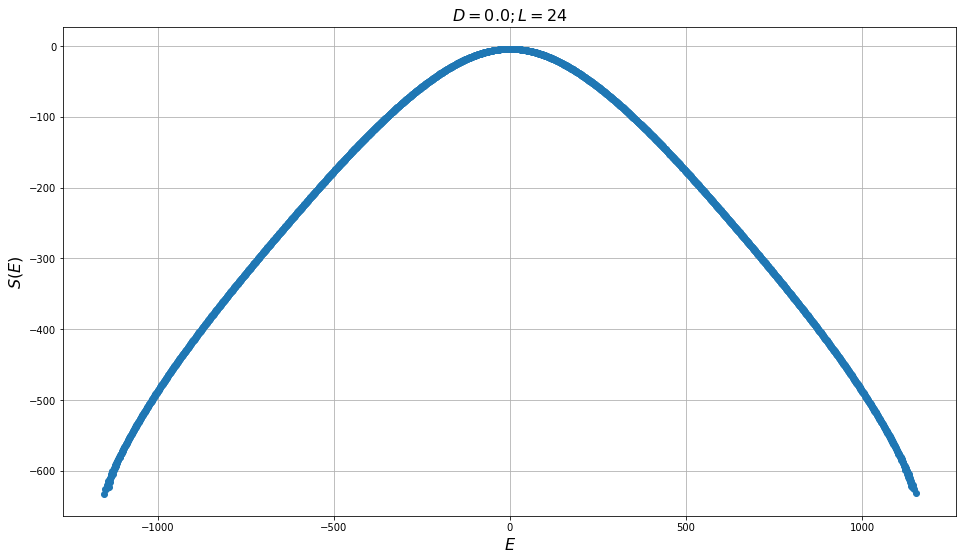

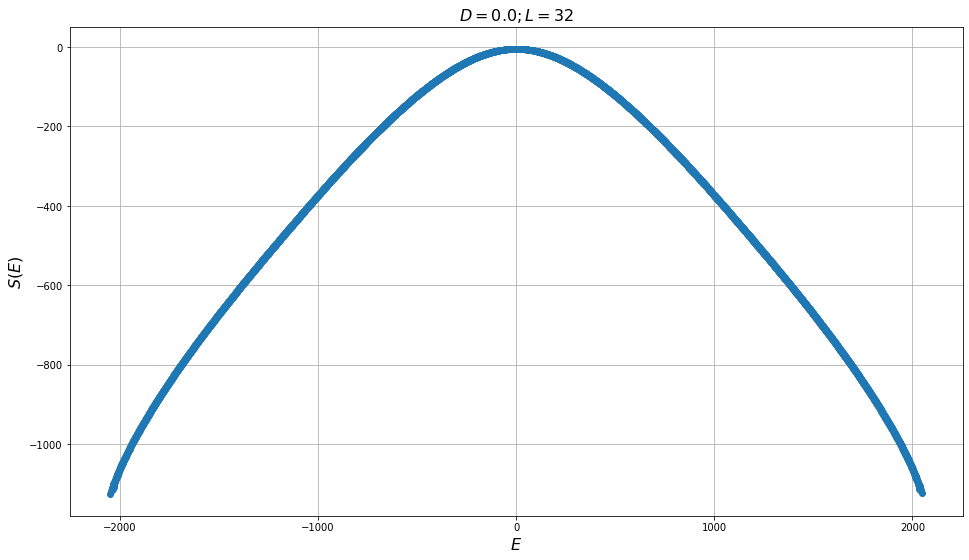

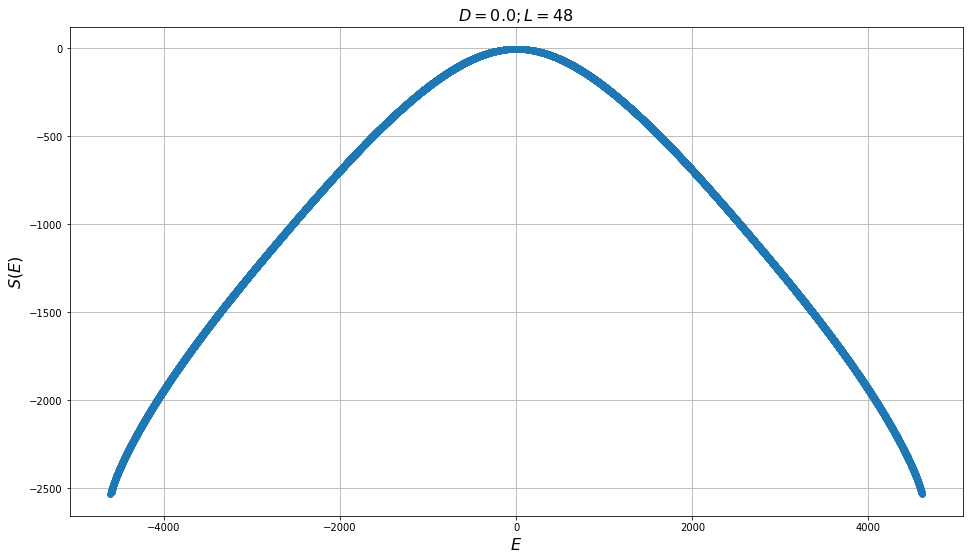

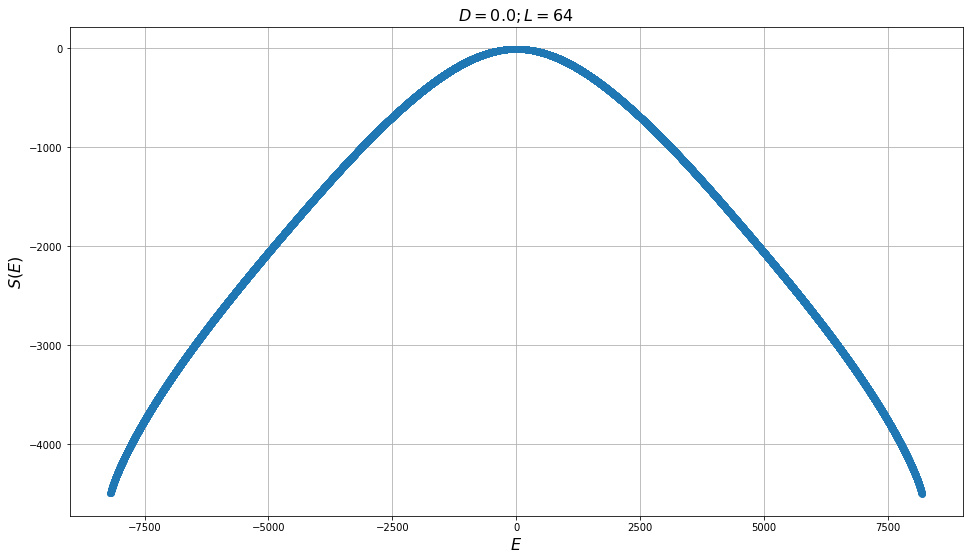

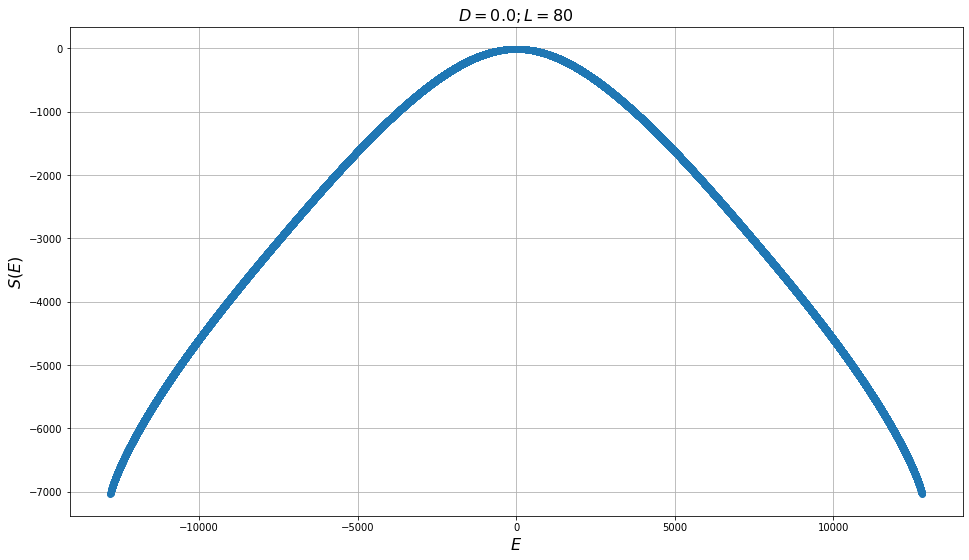

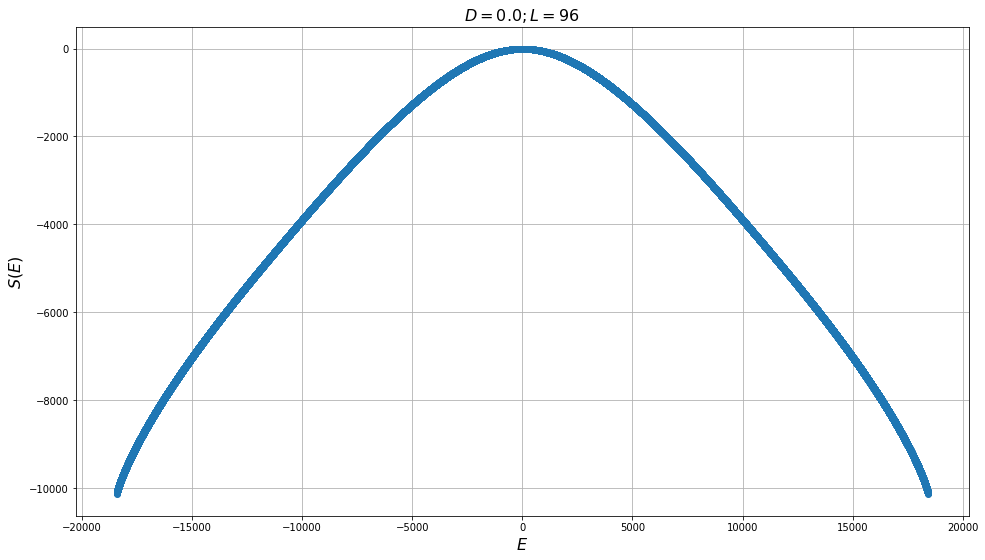

In [8]:
for p in parameters:

    plt.figure(figsize=(16, 9))

    cool, heat, st = p['cool'], p['heat'], p['stitched']

    plt.plot([x for x in st['S']], [y for x, y in st['S'].items()], 'o')
    plt.grid()
    plt.title("$D={}; L={}$".format(st["D"], st["L"], st["R"]), fontsize=16)
    plt.ylabel('$S(E)$', fontsize=16)
    plt.xlabel('$E$', fontsize=16)
    #savefig("./images/S(E)_D{}_L{}.png".format(st["D"], st["L"]))
    plt.show()

In [15]:
D

0.0

In [9]:
hc = {}
E = {}
BC = {}
Z = {}

In [28]:
for i, x in enumerate(tqdm(parameters)):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L

    hc[L] = {}
    E[L] = {}
    BC[L] = {} #Binder Cummulant
    Z[L] = {} #Z(T)

    T_list = np.linspace(0.1, 4.0, 100)
    

    # T, C, average E, BinderCumulant
    for z in Parallel(n_jobs=4)(delayed(calc_hc)(st, T) for T in tqdm(T_list, desc='L={}'.format(L))):
        t, a, b, c, d = z
        hc[L][t], E[L][t], BC[L][t], Z[L][t] = a, b, c, d

    #for T in tqdm(T_list):
    #    T, hc[L][T], E[L][T], BC[L][T] = calc_hc(st, T)


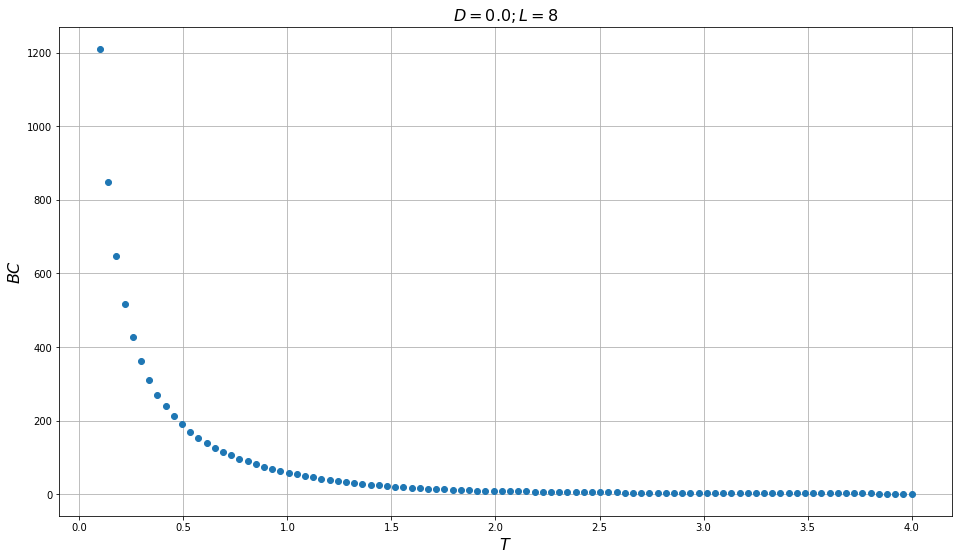

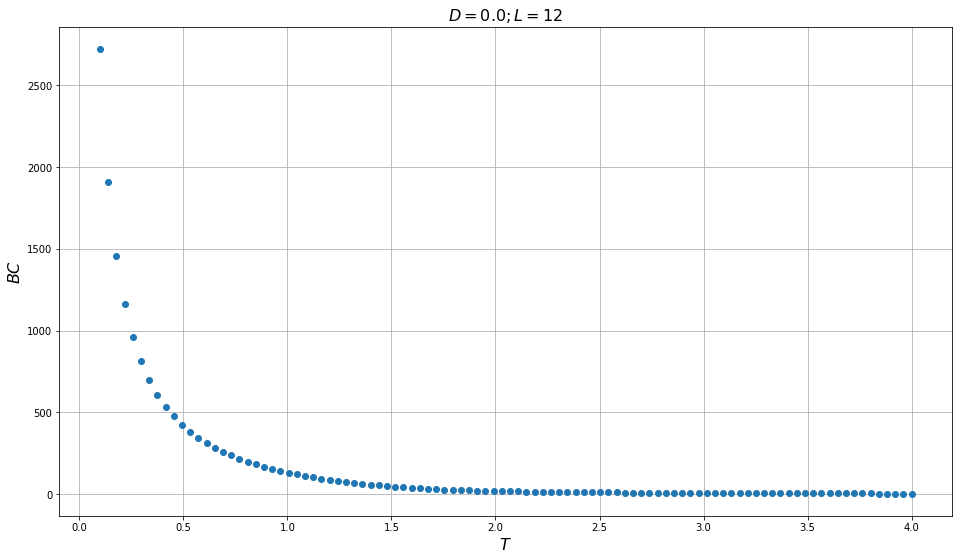

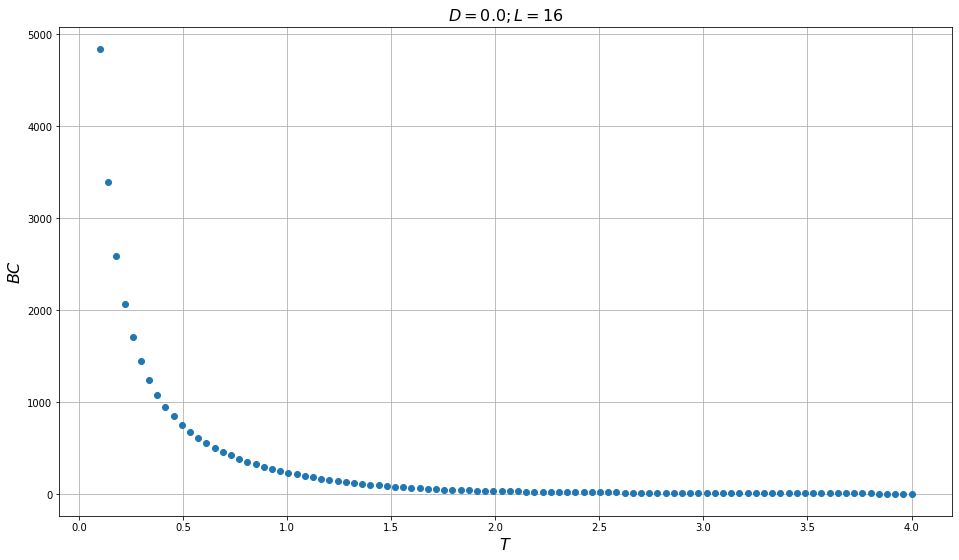

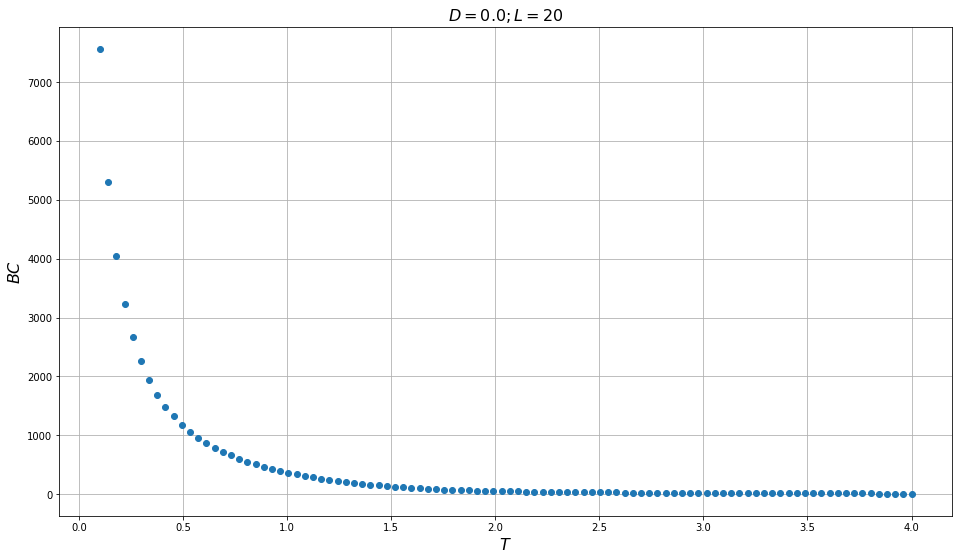

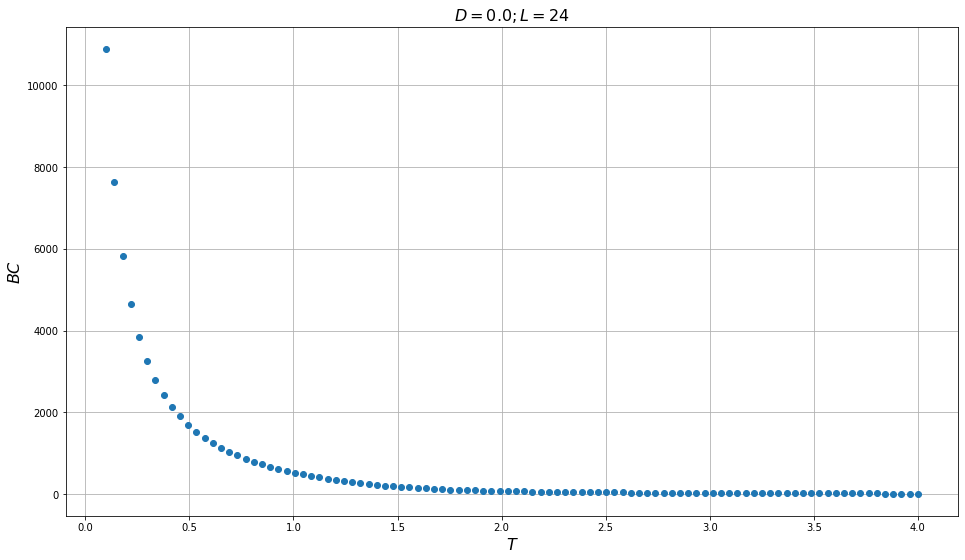

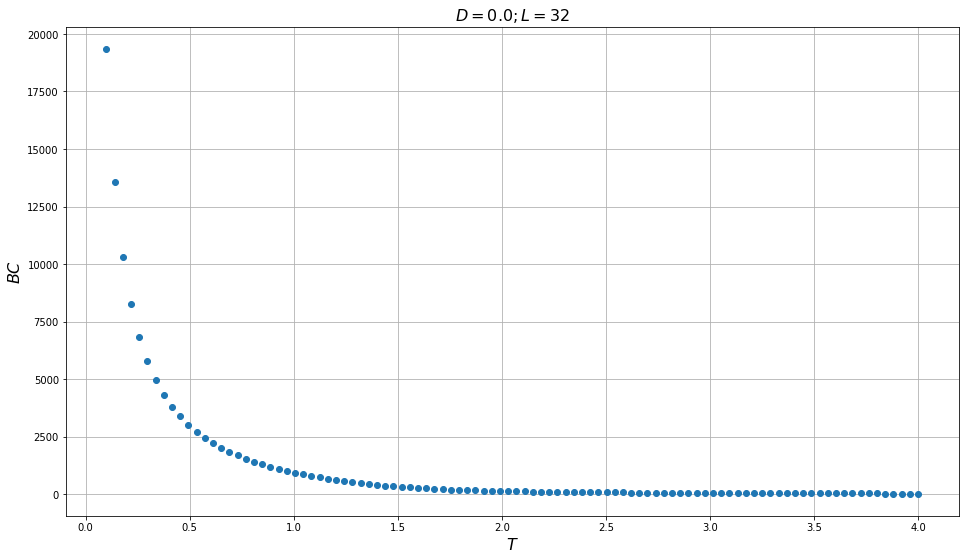

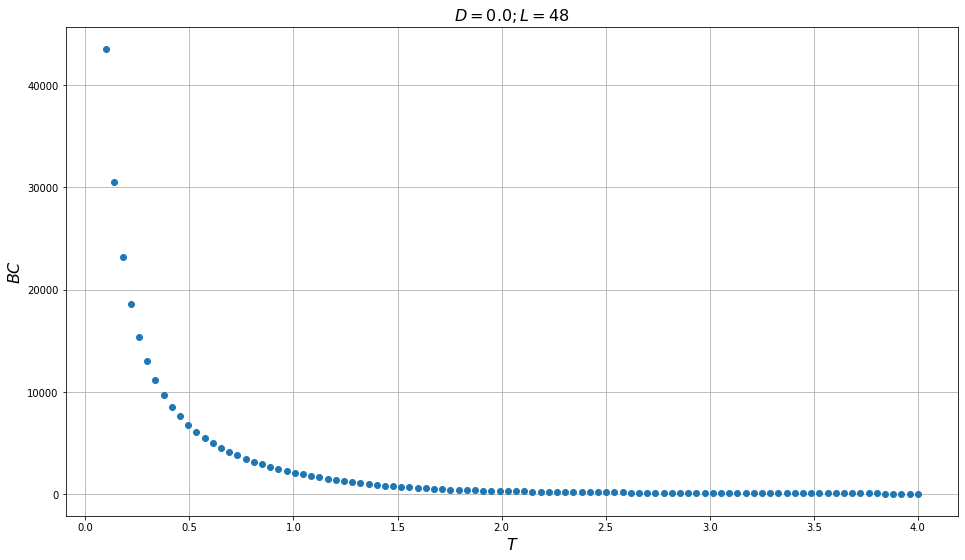

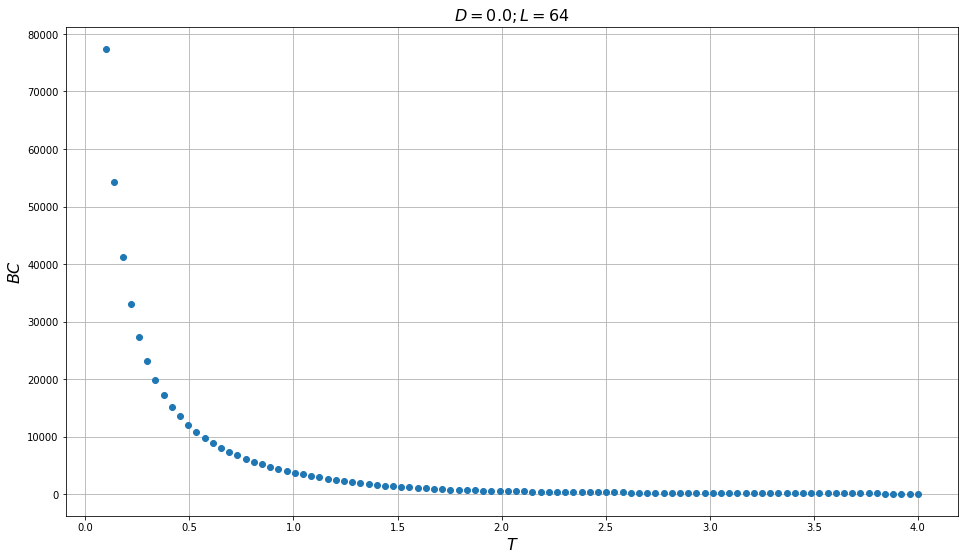

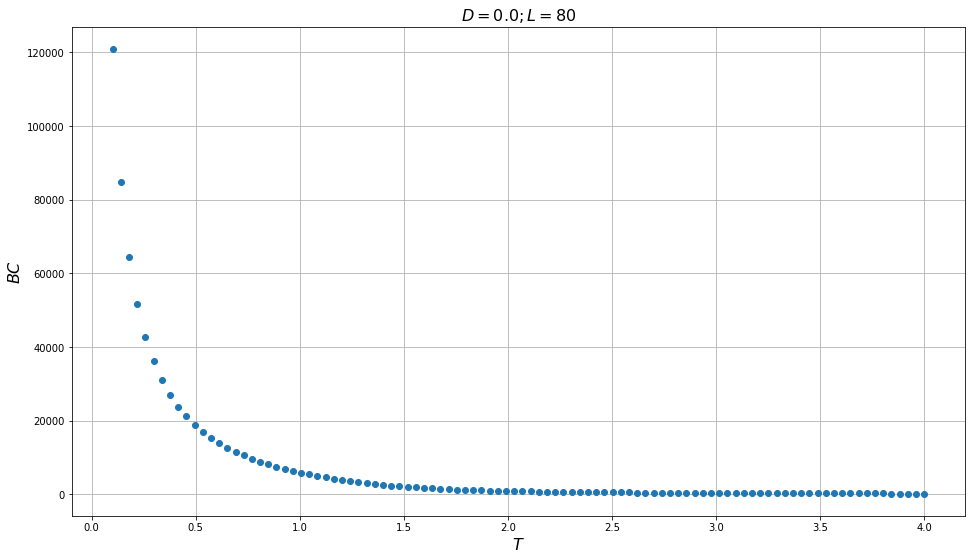

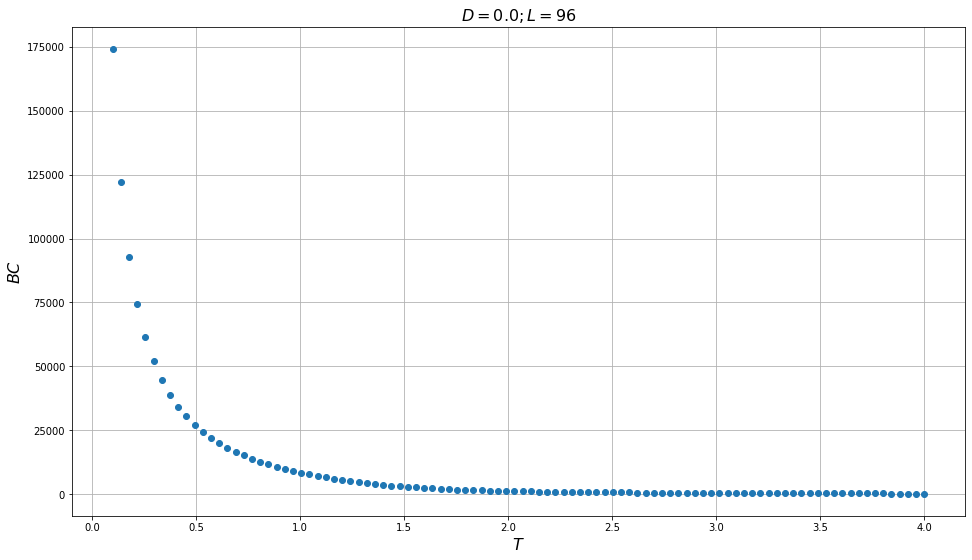

In [34]:
#Z(T) pics
for i, x in enumerate(tqdm(parameters)):
    plt.figure(figsize=(16, 9))
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    

    plt.plot([T for T in Z[L] if T >= 0.0], [mp.ln(z) for T, z in Z[L].items() if T >= 0.0], 'o')
    plt.grid()
    plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
    plt.ylabel('$BC$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    #plt.show()
    plt.savefig("./images/lnZ(T)_D{}_L{}.png".format(st["D"], st["L"]))


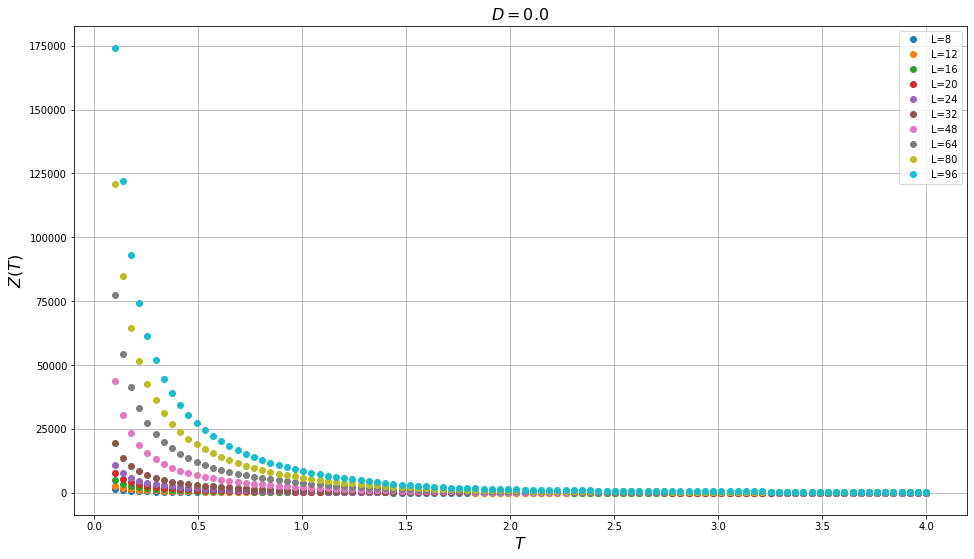

In [33]:
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters)):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    plt.plot([T for T in Z[L]], [mp.ln(z) for T, z in Z[L].items()], 'o', label="L={}".format(L))
plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$Z(T)$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.legend()
#plt.show()
plt.savefig("./images/lnZ(T)_D{}.png".format(st["D"]))

In [21]:
#S(T) = lnZ(T) + E_avg/T pics
#for i, x in enumerate(tqdm(parameters)):
#    plt.figure(figsize=(16, 9))
#    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
#    L = st['L']
#    N = L * L
    

#    plt.plot([T for T in Z[L] if T >= 0.0], [mp.ln(Z[L][T]) for T in Z[L] if T >= 0.0], 'o')
#    plt.grid()
#    plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
#    plt.ylabel('$BC$', fontsize=16)
#    plt.xlabel('$T$', fontsize=16)
#    #plt.show()
#    plt.savefig("./images/lnZ(T)_D{}_L{}.png".format(st["D"], st["L"]))


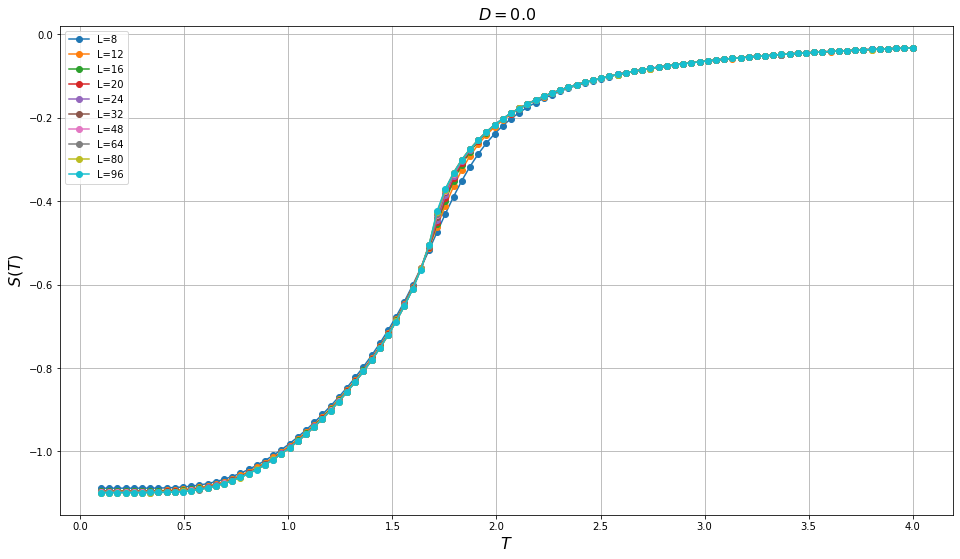

In [37]:
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters)):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    plt.plot([T for T in Z[L]], [(mp.ln(z) + E[L][T]/T)/N for T, z in Z[L].items()], 'o-', label="L={}".format(L))
plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$S(T)$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.legend()
#plt.show()
plt.savefig("./images/entropy_density(T)_D{}.png".format(st["D"]))

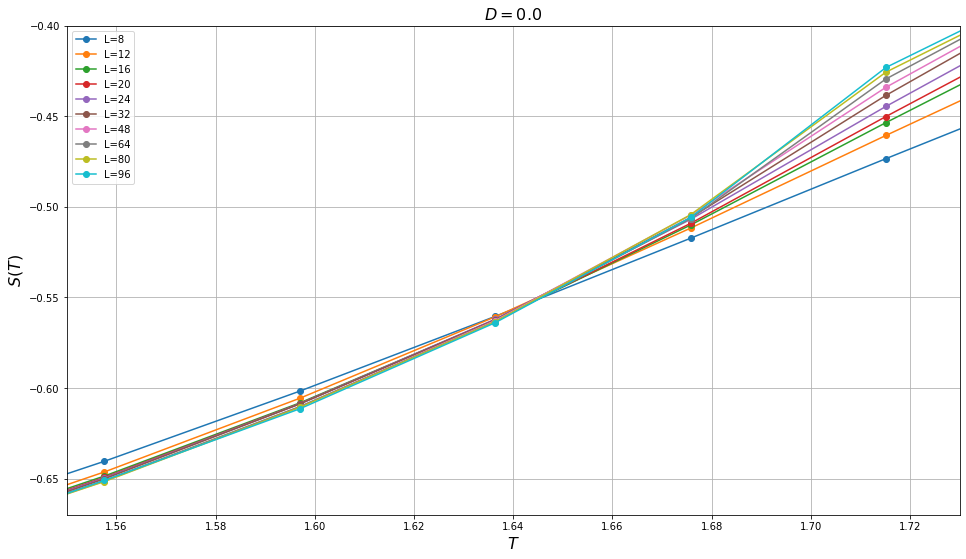

In [50]:
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters)):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    plt.plot([T for T in Z[L]], [(mp.ln(z) + E[L][T]/T)/N for T, z in Z[L].items()], 'o-', label="L={}".format(L))
plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$S(T)$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.xlim([1.55, 1.73])
plt.ylim([-0.67, -0.4])
plt.legend()
plt.show()
#plt.savefig("./images/entropy_density(T)_D{}.png".format(st["D"]))

In [ ]:
#BC pictures
for i, x in enumerate(tqdm(parameters)):
    plt.figure(figsize=(16, 9))
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    

    plt.plot([T for T in BC[L] if T >= 0.0], [c / N for T, c in BC[L].items() if T >= 0.0], 'o')
    plt.grid()
    plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
    plt.ylabel('$BC$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.show()
    #plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


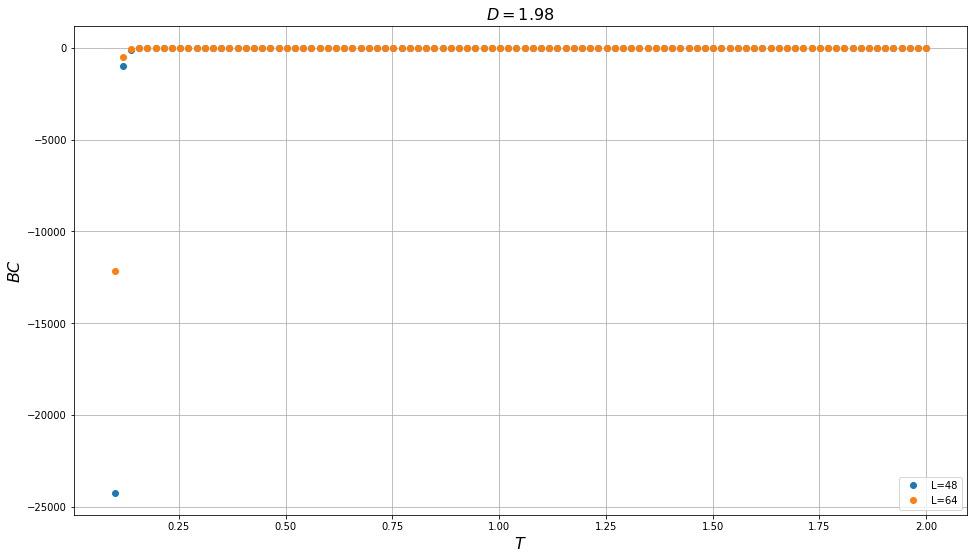

In [17]:
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters)):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    plt.plot([T for T in BC[L]], [c for T, c in BC[L].items()], 'o', label="L={}".format(L))
plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$BC$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.legend()
#plt.show()
plt.savefig("./images/BC(T)_D{}.png".format(st["D"]))

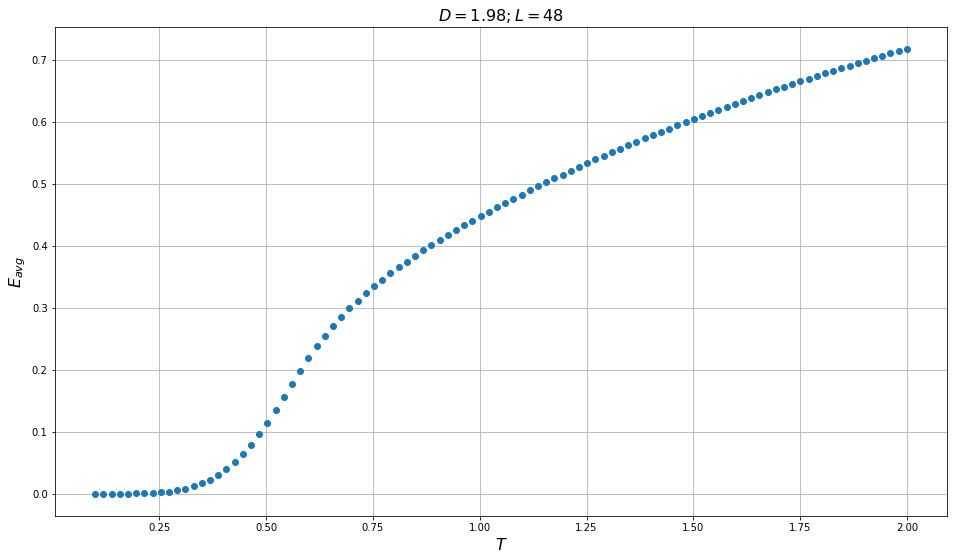

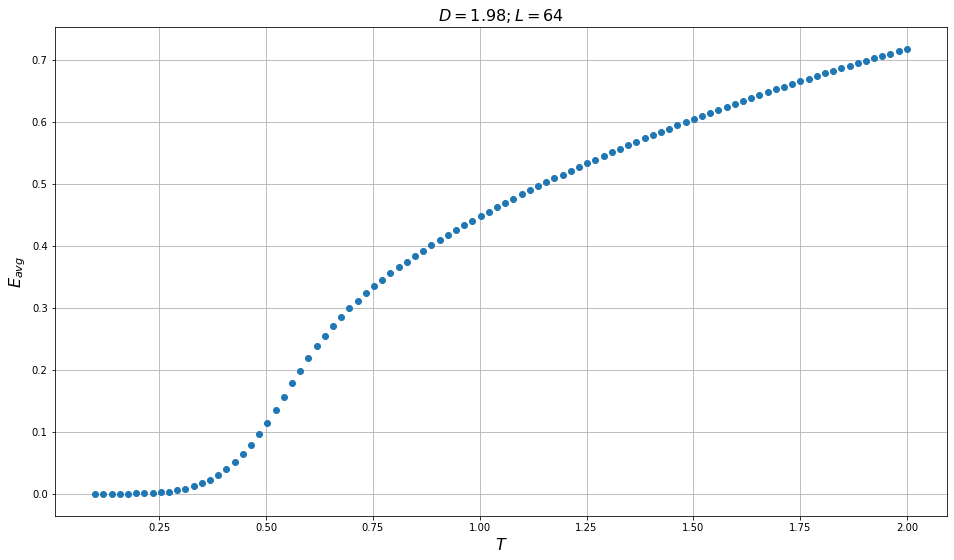

In [18]:
#E_avg pictures
for i, x in enumerate(tqdm(parameters)):
    plt.figure(figsize=(16, 9))
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L


    plt.plot([T for T in E[L]], [e / N for T, e in E[L].items()], 'o')
    plt.grid()
    plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
    plt.ylabel('$E_{avg}$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    #plt.show()
    plt.savefig("./images/E_avg(T)_D{}_L{}.png".format(st["D"], st["L"]))


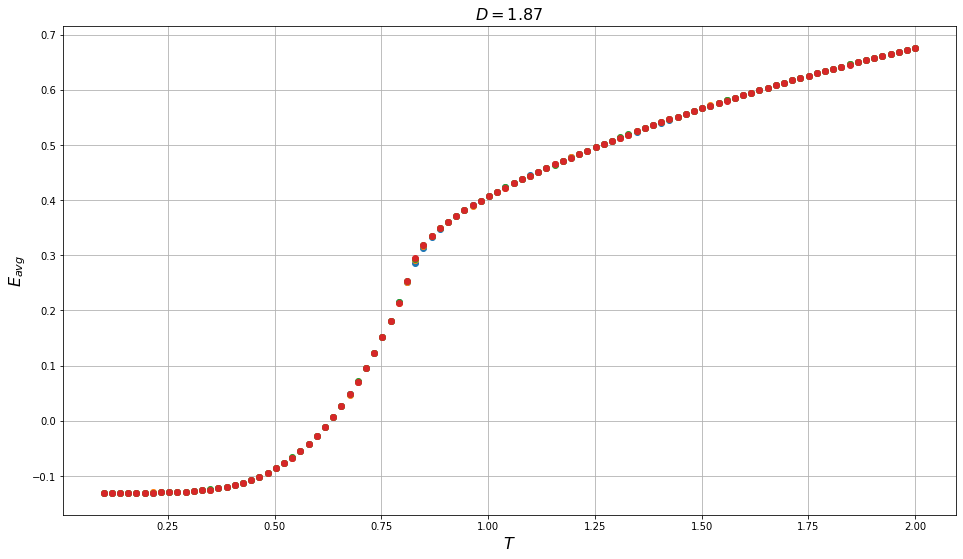

In [22]:
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters)):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    plt.plot([T for T in E[L]], [e / N for T, e in E[L].items()], 'o')
plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$E_{avg}$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
#plt.show()
plt.savefig("./images/E_avg(T)_D{}.png".format(st["D"]))


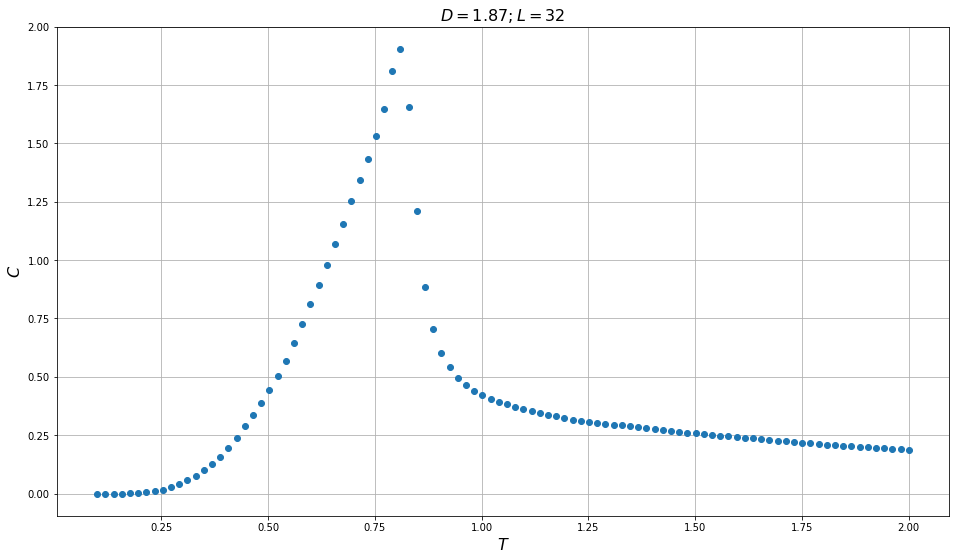

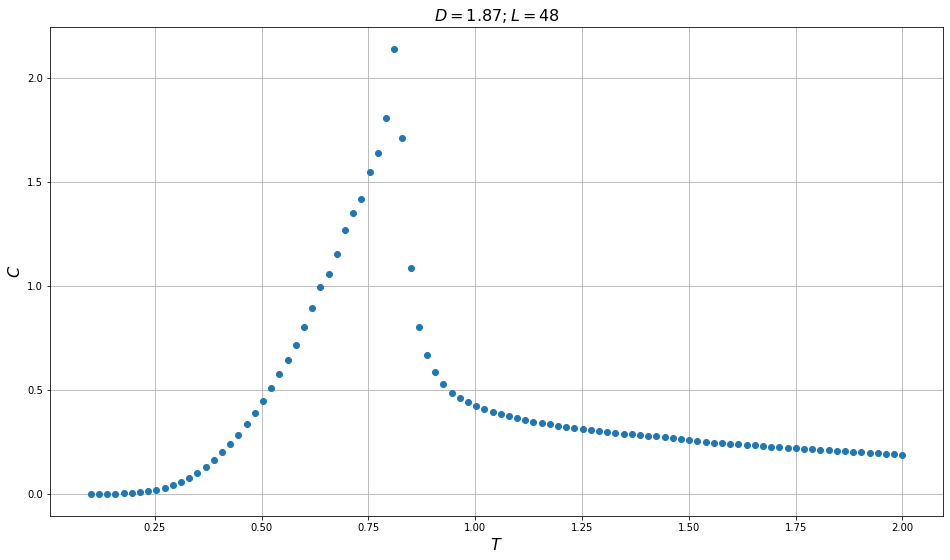

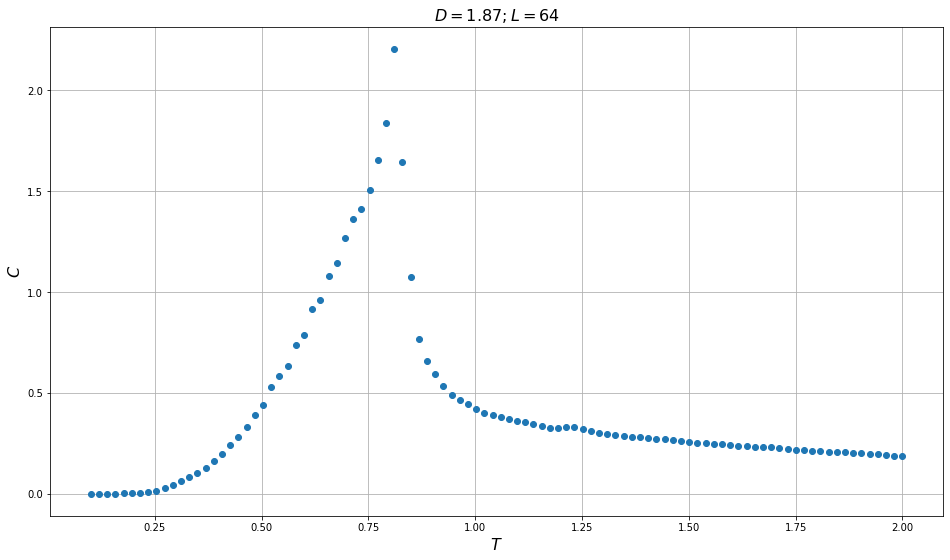

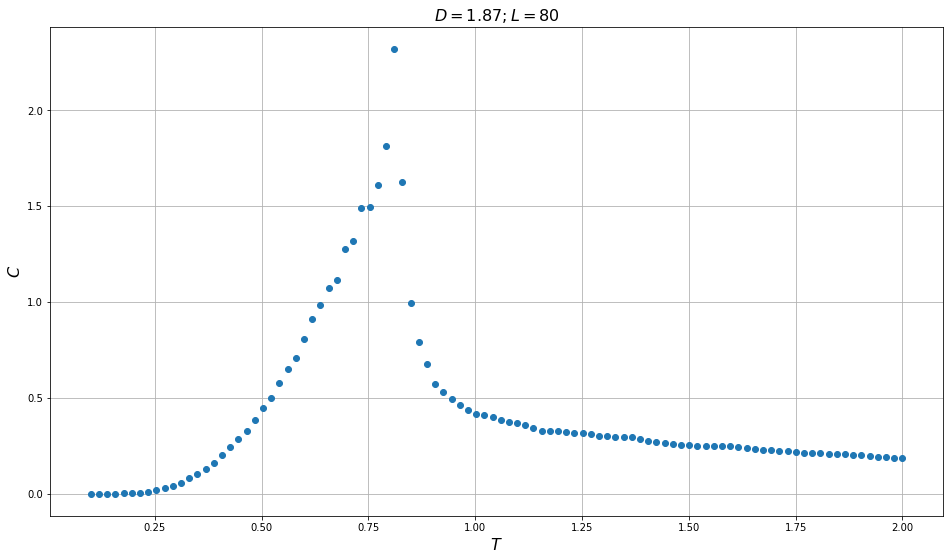

In [23]:
#C pictures
for i, x in enumerate(tqdm(parameters)):
    plt.figure(figsize=(16, 9))
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L


    plt.plot([T for T in hc[L]], [c / N for T, c in hc[L].items()], 'o')
    plt.grid()
    plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
    plt.ylabel('$C$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    #plt.show()
    plt.savefig("./images/C(T)_D{}_L{}.png".format(st["D"], st["L"]))


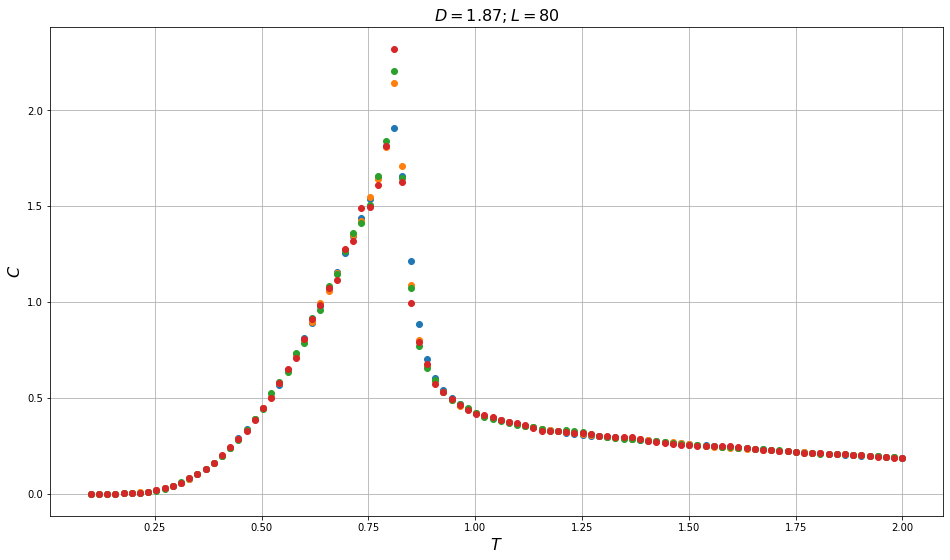

In [24]:
plt.figure(figsize=(16, 9))
for i, x in enumerate(tqdm(parameters)):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    plt.plot([T for T in hc[L]], [c / N for T, c in hc[L].items()], 'o')
plt.grid()
plt.title("$D={}; L={}$".format(st["D"], st["L"]), fontsize=16)
plt.ylabel('$C$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
#plt.show()
plt.savefig("./images/C(T)_D{}.png".format(st["D"]))


In [5]:
Z = {}
E = {}

In [32]:
for D in [0.0, 0.5, 1.0, 1.5, 1.6, 1.7, 1.75, 1.87, 1.9, 1.92, 1.94, 1.95, 1.96, 1.962, 1.964, 1.965, 1.965, 1.966, 1.967, 1.97, 1.98, 1.99]:
    with open('./tmp/T_crit_D{}.txt'.format(D), 'r') as f:
        T_crit = json.load(f)

    with open('./tmp/T_crit_D{}.tsv'.format(D), 'w') as f:
        f.write('L\tT_crit\tC_crit\n');
        for L in T_crit:
            f.write('\t'.join([L, str(T_crit[L]['T_crit']), str(T_crit[L]['C_crit'])]) + '\n')


In [8]:
for D in [0.0, 0.5, 1.0, 1.5, 1.6, 1.7, 1.75, 1.87, 1.9, 1.92, 1.94, 1.95, 1.96, 1.962, 1.964, 1.965, 1.965, 1.966, 1.97, 1.98]:
    with open("./cluster_tmp/lnZ_D{}.txt".format(D), 'r') as fp:
        Z[D] = json.load(fp)
    with open("./cluster_tmp/E_D{}.txt".format(D), 'r') as fp:
        E[D] = json.load(fp)

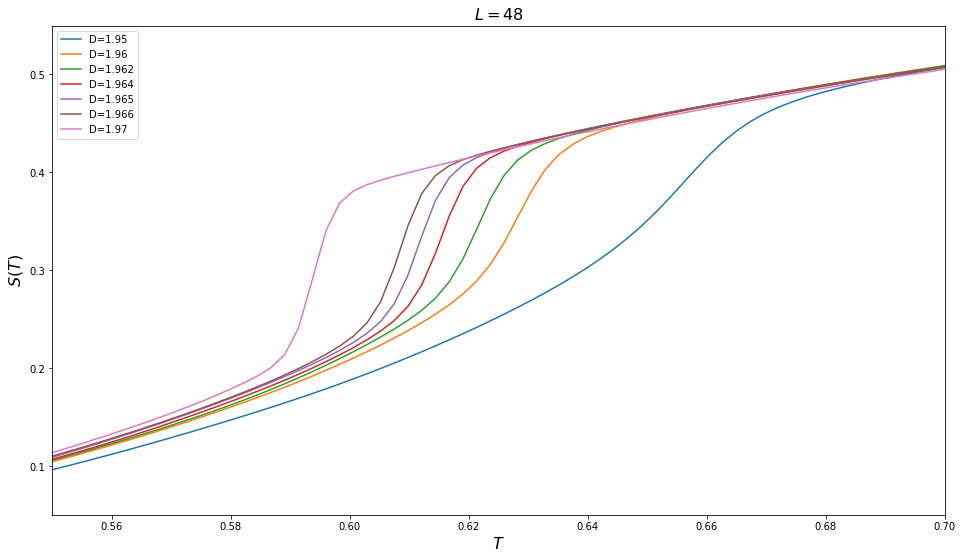

In [48]:
L = '48'
plt.figure(figsize=(16, 9))

N = int(L) * int(L)
for D in Z.keys():
    if not (D >= 1.95 and D <= 1.97):
        continue
    plt.plot([float(T) for T in Z[D][L]],
         [1 + (z + float(E[D][L][T]) / float(T) ) / N for T, z in Z[D][L].items()], '-', label="D={}".format(D))

#plt.grid()
plt.title("$L={}$".format(L), fontsize=16)
plt.ylabel('$S(T)$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.xlim([0.55, 0.7])
plt.ylim([0.05, 0.55])
plt.legend()
#plt.show()
plt.savefig("./images/entropy_density(T)_Kim.png")

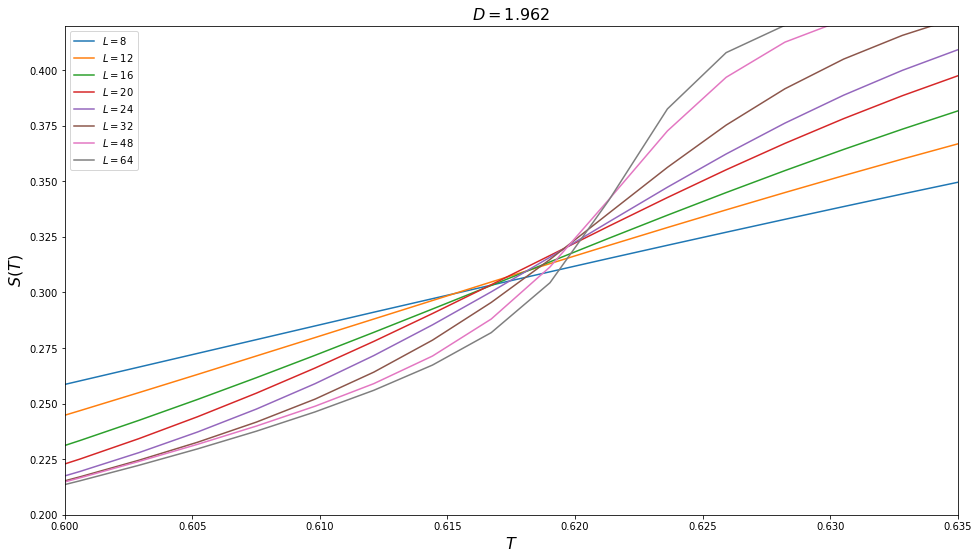

In [57]:
D = 1.962
plt.figure(figsize=(16, 9))

for L in Z[D].keys():
    N = int(L) * int(L)
    if not (D >= 1.95 and D <= 1.97):
        continue
    plt.plot([float(T) for T in Z[D][L]],
         [1 + (z + float(E[D][L][T]) / float(T) ) / N for T, z in Z[D][L].items()], '-', label="$L={}$".format(L))

#plt.grid()
plt.title("$D={}$".format(D), fontsize=16)
plt.ylabel('$S(T)$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.xlim([0.6, 0.635])
plt.ylim([0.2, 0.42])
plt.legend()
#plt.show()
plt.savefig("./images/entropy_density(T)_Kim2.png")